In [1]:
%load_ext autoreload
%autoreload 2

from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScaledScore_fSin_T256_H05_tl_5data import get_config as get_config_PMS
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_PostMeanScore_fSin_T256_H05_tl_5data import get_config as get_config_PM
from configs.RecursiveVPSDE.Markovian_fSin.recursive_Markovian_fSinWithPosition_T256_H05_tl_5data import get_config as get_config_TS

from configs import project_config
import numpy as np
import torch

import matplotlib.pyplot as plt

In [2]:
config_TS = get_config_TS()
config_PM = get_config_PM()
config_PMS = get_config_PMS()
assert(config_TS.beta_min == config_PM.beta_min == config_PMS.beta_min)
assert(config_TS.ts_length == config_PM.ts_length == config_PMS.ts_length)
assert (config_TS.max_diff_steps == config_PM.max_diff_steps == config_PMS.max_diff_steps == 1000)
Delta = 1./config_TS.ts_length

In [3]:
assert(config_TS.data_path == config_PM.data_path == config_PMS.data_path)
true_data = np.load(config_TS.data_path)

T = true_data.shape[1]
print(true_data.shape)

(200000, 256)


In [4]:
from scipy.stats import wasserstein_distance
import ot
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for X
    b = np.ones((sample1.shape[0],)) / sample1.shape[0]  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    print(a.shape, b.shape, M.shape)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    fig, ax = plt.subplots(figsize=(14, 9))
    counts, bins, patches  = ax.hist(bootstrap_distances, bins=150, alpha=0.75,density=True)
    ax.set_title("Histogram of Permutation-Test Wasserstein Distances", fontsize=20)
    ax.axvline(observed_distance, 0, np.max(counts), color="orange", label="Observed Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distances", fontsize=20)
    ax.set_ylabel("Normalised Count", fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    plt.savefig("/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/wassersteindistances.png")
    plt.show()
    plt.close()
    p_value = np.mean(bootstrap_distances >= observed_distance)
    #print(bootstrap_distances, observed_distance, p_value)

    return observed_distance, p_value

In [5]:
def moment_calculations(data):
    from scipy.stats import moment
    try:
        data = data.numpy()
    except AttributeError as e:
        print(e)
        pass
    means = np.mean(data, axis=0)
    assert(means.shape[0] == data.shape[1])
    vars, skew, kurt = moment(data, moment=[2,3,4], axis=0)
    assert(means.shape == vars.shape == skew.shape == kurt.shape)
    return means, vars, skew, kurt

In [6]:
def plot_ts(ax, ts, T, label, moment):
    time_axis = np.linspace(Delta, Delta*T, T)
    plt.plot(time_axis, ts, label=f"{label}")
    ax.set_title(f"Empirical {moment}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.legend(fontsize=25)

In [7]:
true_m, true_v, true_s, true_k = moment_calculations(true_data[np.random.choice(np.arange(true_data.shape[0]), 1000),:])

'numpy.ndarray' object has no attribute 'numpy'


(1000,) (1000,) (1000, 1000)


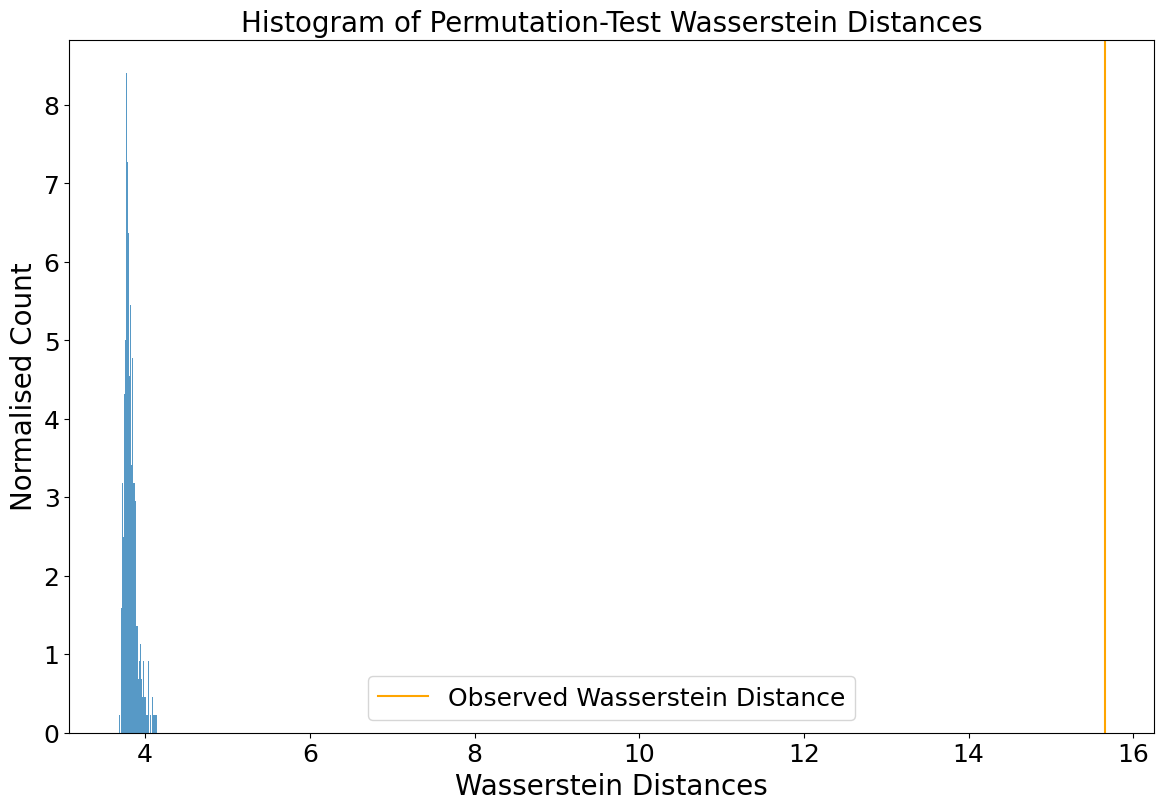

ES 0 with p val 0.0
PM 0
(1000,) (1000,) (1000, 1000)


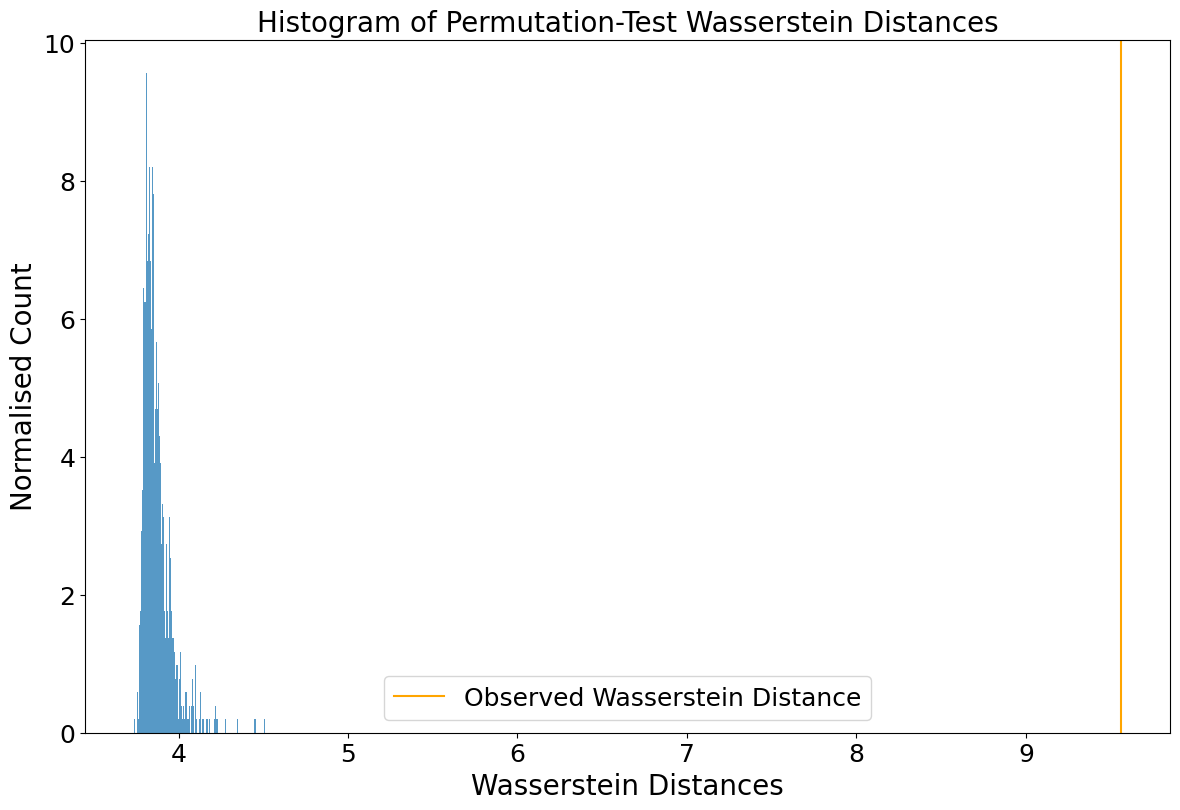

ES 3 with p val 0.0
PM 3
(1000,) (1000,) (1000, 1000)


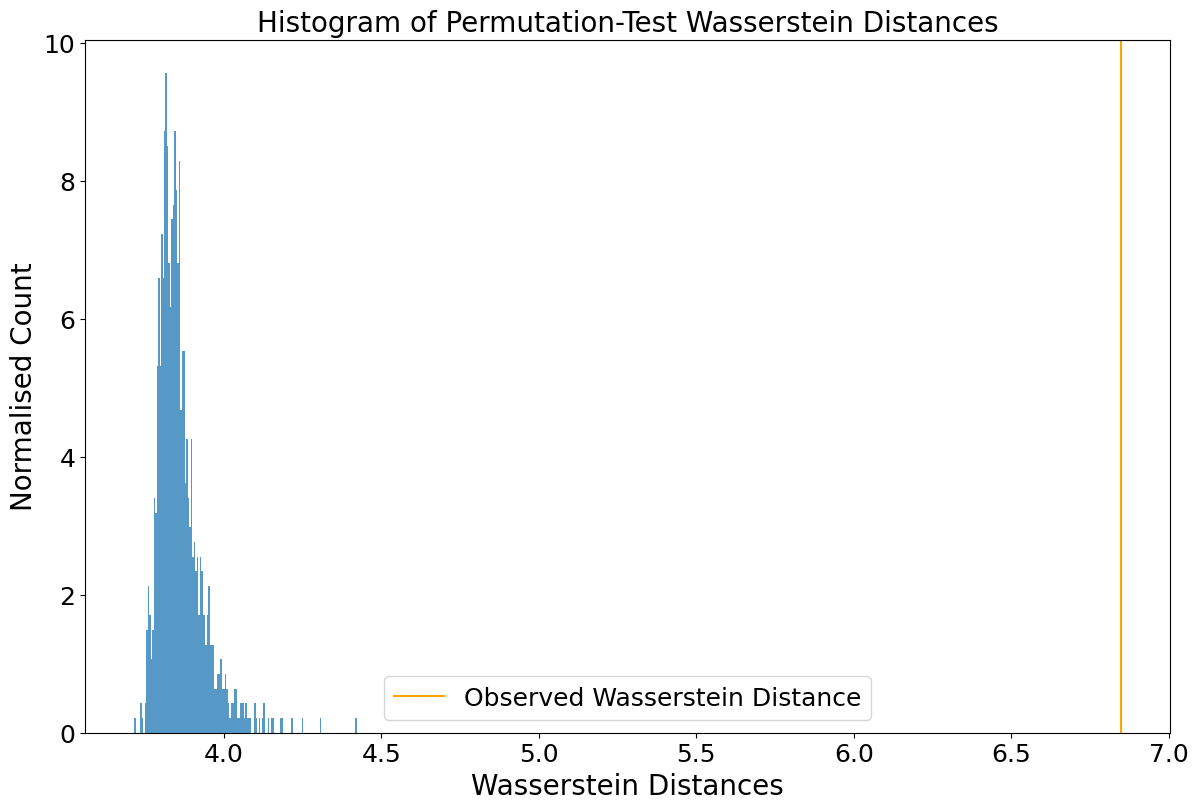

ES 5 with p val 0.0
PM 5
(1000,) (1000,) (1000, 1000)


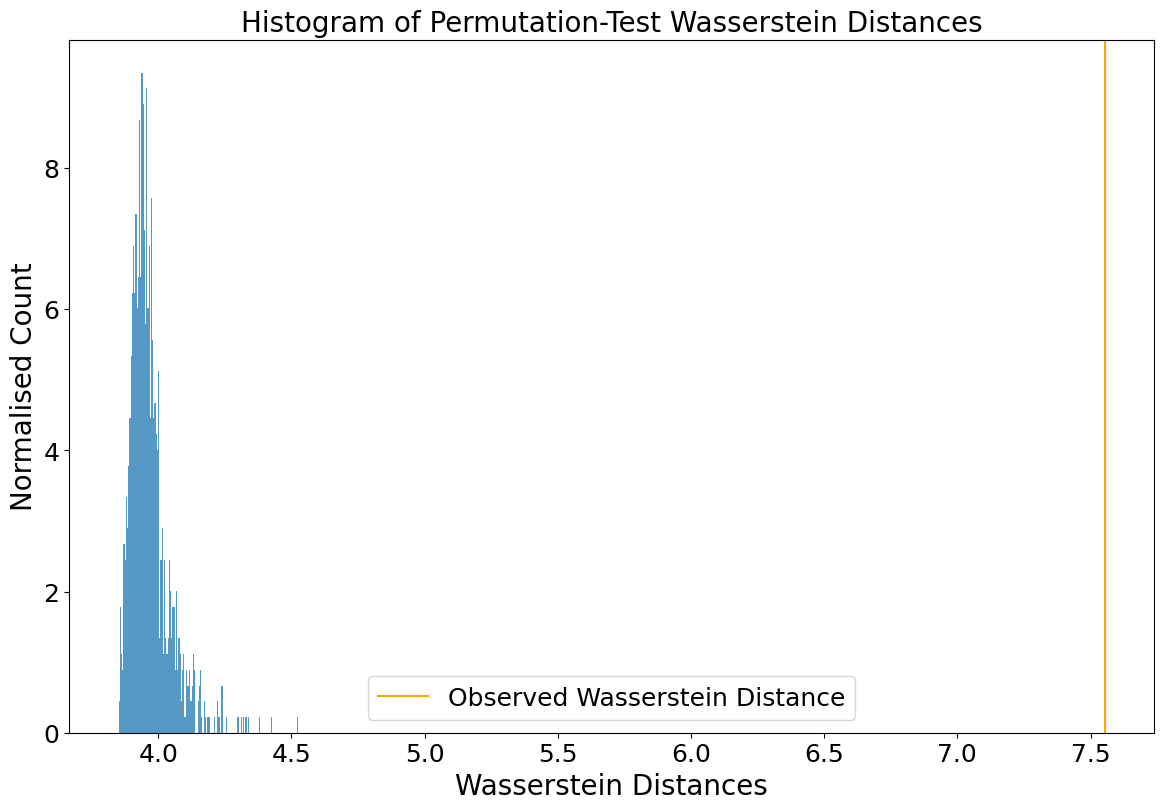

ES 7 with p val 0.0
PM 7
(1000,) (1000,) (1000, 1000)


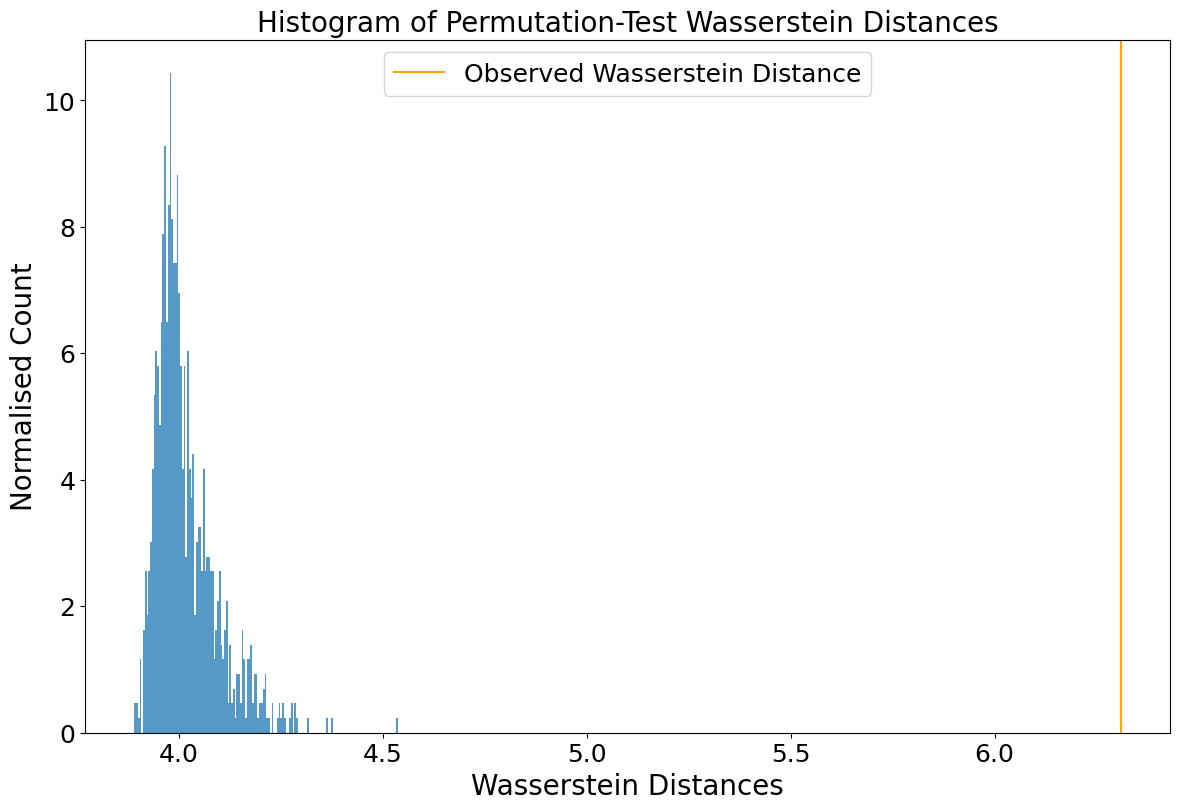

ES 10 with p val 0.0
PM 10
(1000,) (1000,) (1000, 1000)


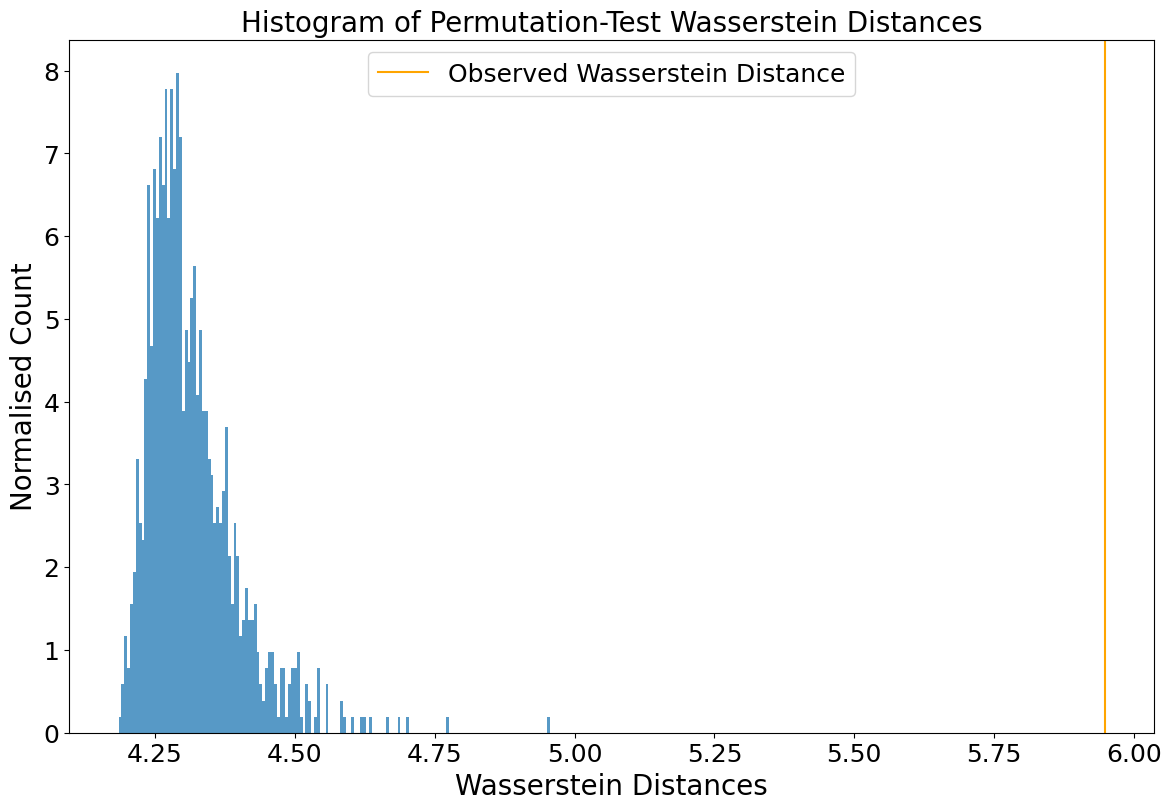

ES 15 with p val 0.0
PM 15
(1000,) (1000,) (1000, 1000)


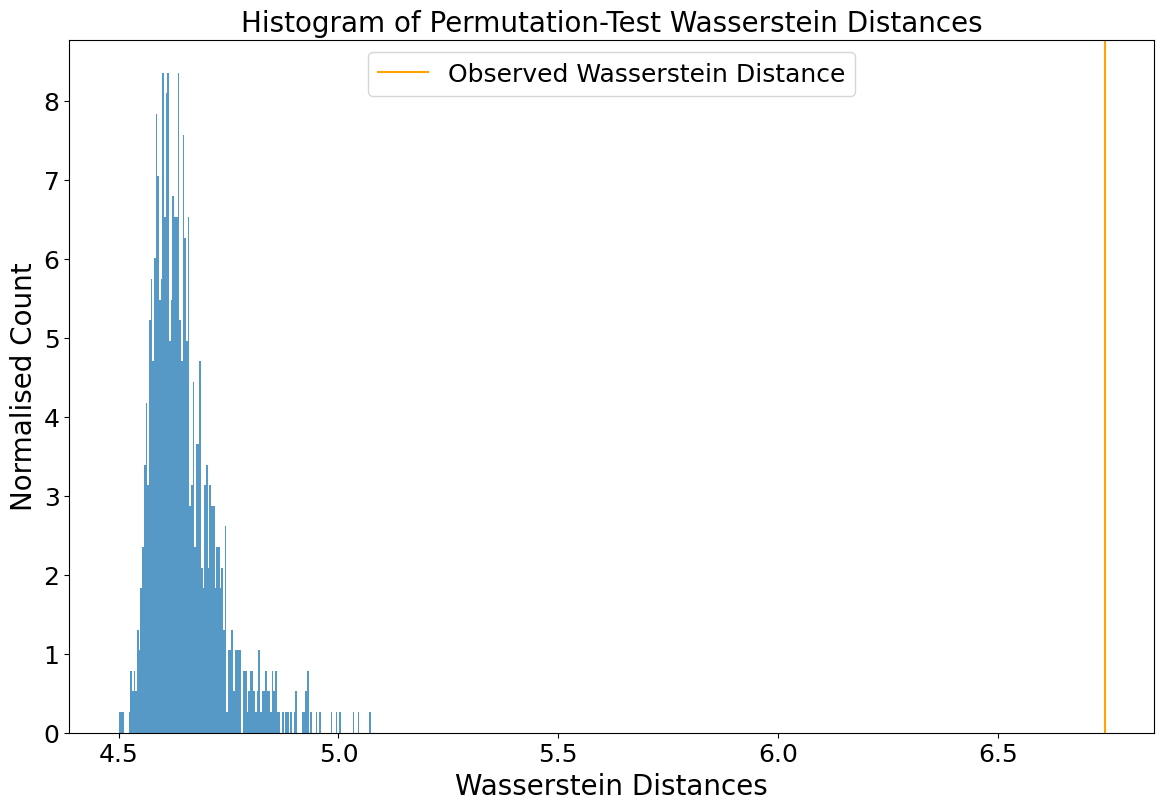

ES 20 with p val 0.0
PM 20


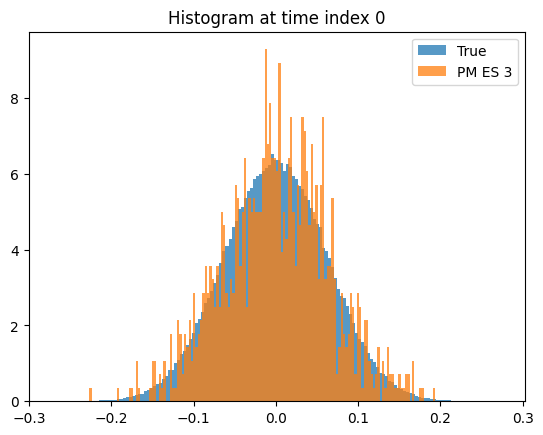

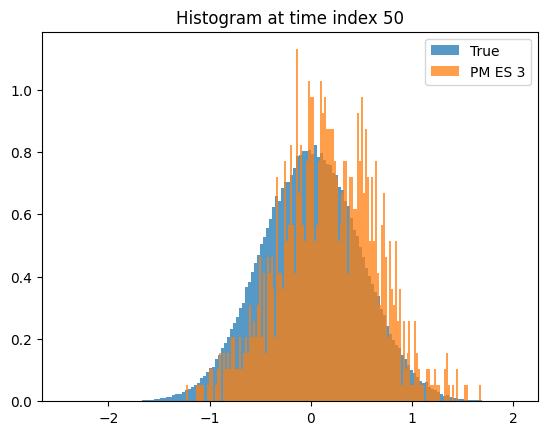

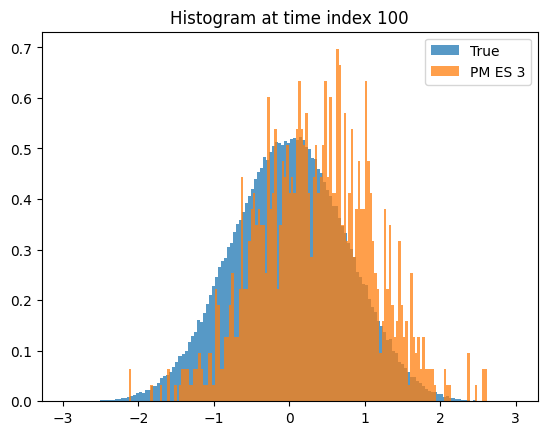

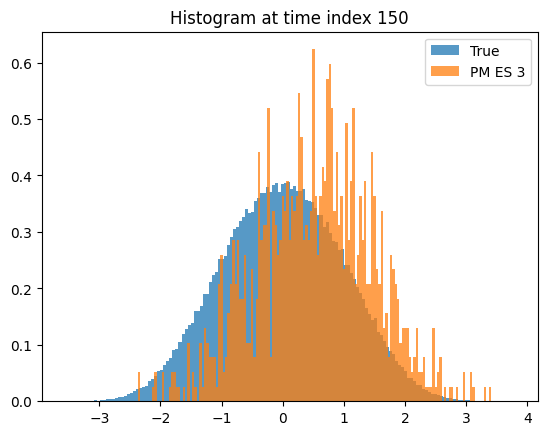

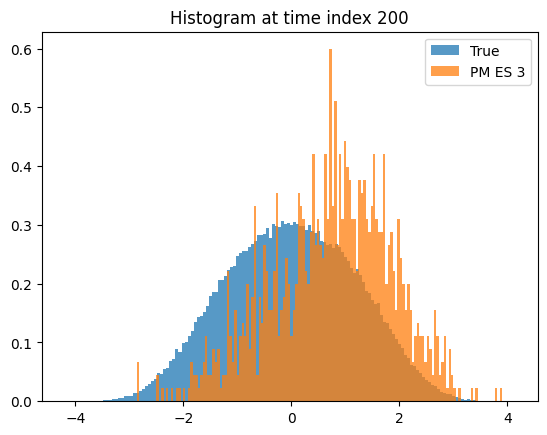

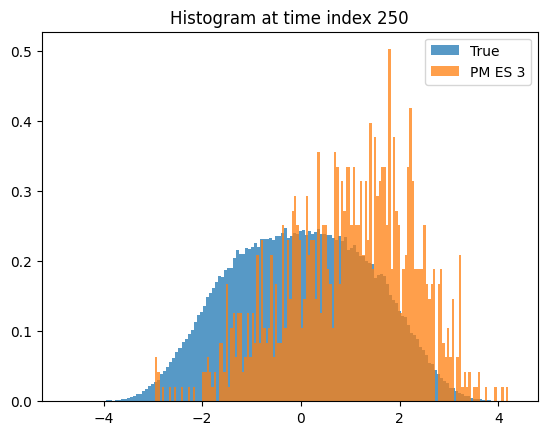

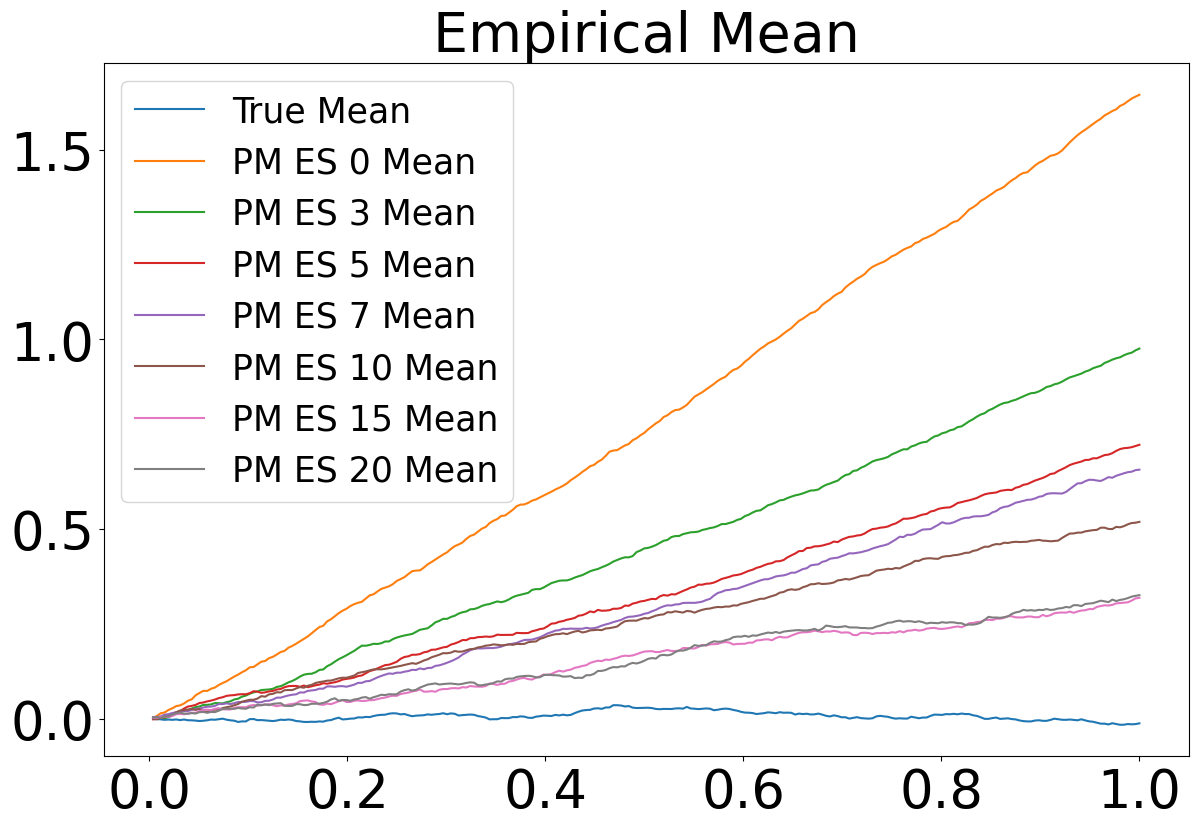

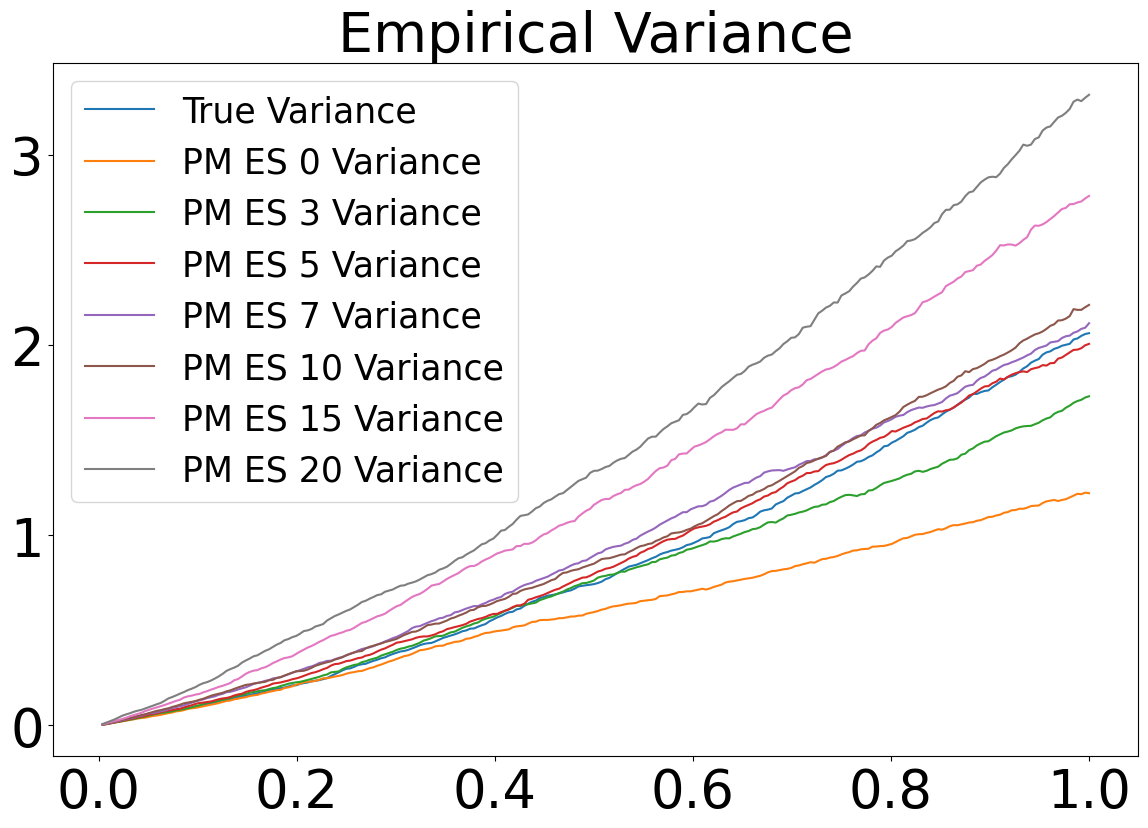

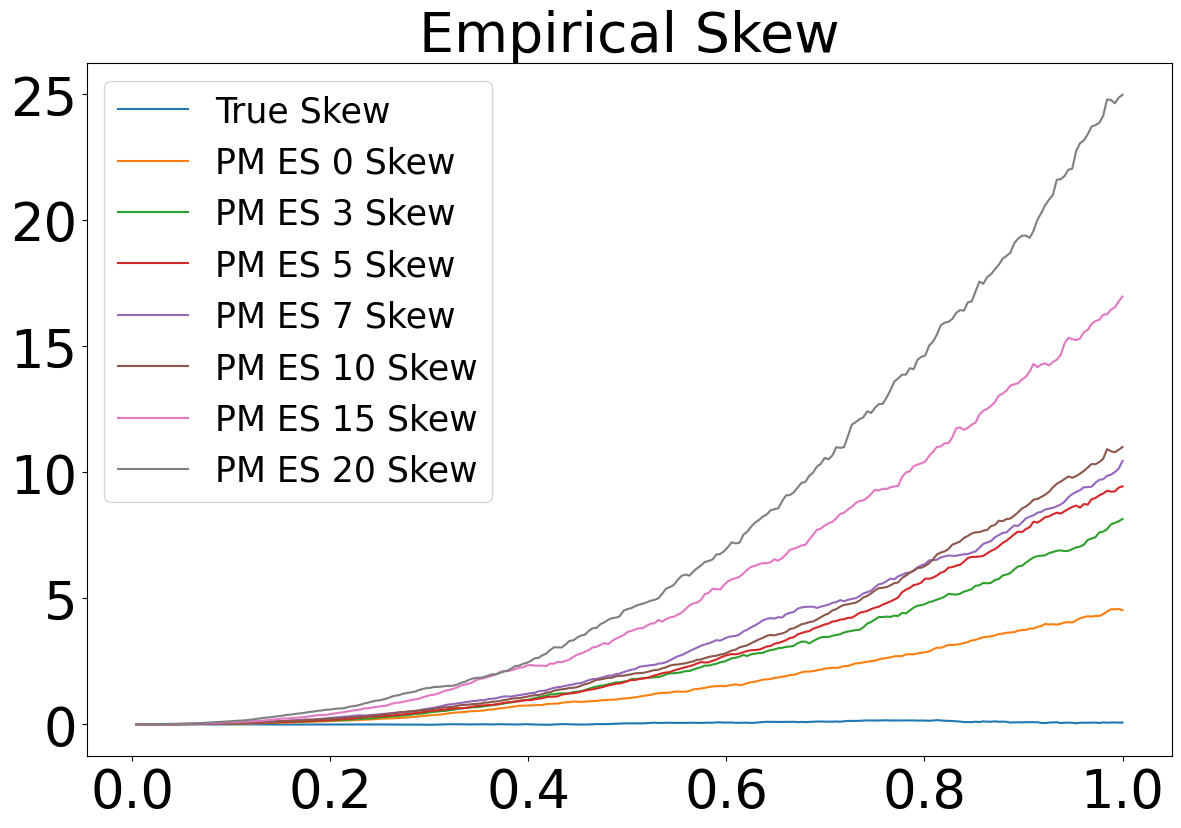

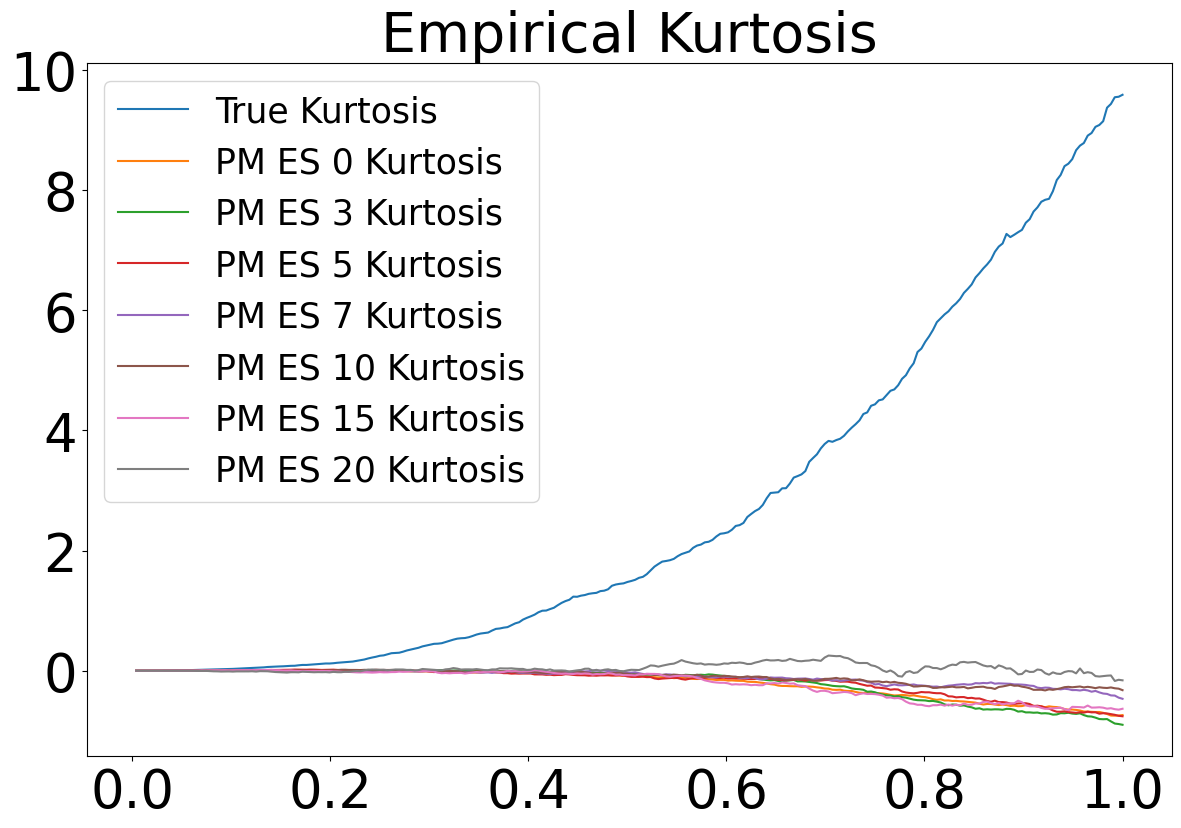

In [8]:
Nepoch = 960
means = [true_m]
vars = [true_v]
skews = [true_s]
kurt = [true_k]
ppaths = [true_data]
for config in [config_PM]:
    Ndiff = config.max_diff_steps
    for es in [0,3,5,7,10,15,20]:
        if "PMS" in config.scoreNet_trained_path:
            type = "PMS"
        elif "PM" in config.scoreNet_trained_path:
            type = "PM"
        else:
            type = ""
        try:
            file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_ES{es}_fSin_PathGen_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
            if type == "":
                type="Standard"
            paths = torch.load(file_path+"paths")
            paths = paths[np.random.choice(np.arange(paths.shape[0]), 1000), 1:T+1]
            print(f"ES {es} with p val {bootstrap_test_wasserstein(paths.numpy(), true_data[np.random.choice(np.arange(true_data.shape[0]), paths.shape[0]),:])[1]}")
            ppaths.append(paths)
            print(type, es)
            if type == "":
                type="Standard"
            m, v, k, s = moment_calculations(paths)
            means.append(m)
            vars.append(v)
            skews.append(s)
            kurt.append(k)
        except FileNotFoundError as e:
            print(e)

for t in range(0,ppaths[0].shape[1], 50):
    for i in range(len(ppaths)):
        if i == 0:
            label = "True"
            plt.hist(ppaths[i][:, t], bins=150, density=True, alpha=0.75, label=label)
        elif i == 1:
            label = f"{type} ES 0"
        elif i == 2:
            label = f"{type} ES 3"
            plt.hist(ppaths[i][:, t], bins=150, density=True, alpha=0.75, label=label)
        elif i == 3:
            label = f"{type} ES 5"
        elif i == 4:
            label = f"{type} ES 7"
        elif i ==5:
            label = f"{type} ES 10"
        elif i == 6:
            label=f"{type} ES 15"
        elif i == 7:
            label=f"{type} ES 20"


#        plt.hist(ppaths[i][:, t], bins=150, density=True, alpha=0.75, label=label)
    plt.title(f"Histogram at time index {t}")
    plt.legend()
    plt.show()
    plt.close()
for mom in ["Mean", "Variance", "Skew", "Kurtosis"]:
    if mom == "Mean":
        ts = means
    elif mom == "Variance":
        ts = vars
    elif mom == "Skew":
        ts = skews
    else:
        ts = kurt
    fig, ax = plt.subplots(figsize=(14,9))
    for i in range(len(ppaths)):
        if i == 0:
            label = "True"
        elif i == 1:
            label = f"{type} ES 0"
        elif i == 2:
            label = f"{type} ES 3"
        elif i == 3:
            label = f"{type} ES 5"
        elif i == 4:
            label = f"{type} ES 7"
        elif i ==5:
            label = f"{type} ES 10"
        elif i == 6:
            label=f"{type} ES 15"
        elif i == 7:
            label=f"{type} ES 20"
        plot_ts(ax=ax, ts=ts[i], T=T,label=f"{label} {mom}", moment=f"{mom}")
    plt.show()
    plt.close()